In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import os
import cv2

from collections import defaultdict

%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.6f}'.format

import gym
from gym.wrappers import Monitor
import gym_ple

env = gym.make('FlappyBird-v0')

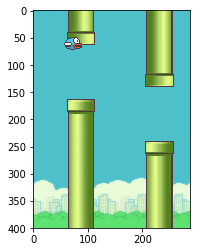

In [153]:
env.reset()

for _ in range(80):
    s, r, done, _ = env.step(env.action_space.sample())
plt.imshow(s[:-112])

In [397]:
from skimage.io import imread
from itertools import product

pipes = ['pipe-red.png', 'pipe-green.png']
birbs = ['bluebird-upflap.png', 'redbird-downflap.png', 'yellowbird-midflap.png', 'yellowbird-downflap.png',
         'bluebird-downflap.png', 'bluebird-midflap.png', 'redbird-upflap.png', 'yellowbird-upflap.png',
         'redbird-midflap.png']
backgrounds = ['background-day.png', 'background-night.png']

folder = "pics"

BG_LABEL = 0
PIPE_LABEL = 1
BIRB_LABEL = 2
WHATEVER_LABEL = 255

def load_set(pipe, birb, background):
    pipe = imread(os.path.join(folder, pipe))
    birb = imread(os.path.join(folder, birb))
    background = imread(os.path.join(folder, background))[:-112]
    
    pipe_mask, birb_mask, bg_mask = make_masks(pipe, birb, background)
    inv_pipe, inv_pipe_mask = invert_pipe_image(pipe, pipe_mask)
    
    return {"pipe":pipe, "birb":birb, "bg":background, "pipe_mask":pipe_mask, 
            "birb_mask": birb_mask, "bg_mask": bg_mask, 
            "inv_pipe":inv_pipe, "inv_pipe_mask":inv_pipe_mask}

def generate_all_sets():
    all_sets = product(pipes, birbs, backgrounds)
    
    return list(map(lambda x: load_set(*x), all_sets))

def get_random_parts():
    pipe = os.path.join(folder, np.random.choice(pipes))
    birb = os.path.join(folder, np.random.choice(birbs))
    background = os.path.join(folder, np.random.choice(backgrounds))
    
    return imread(pipe), imread(birb), imread(background)[:-112]

def combine_masks(orig_image, whole_mask, object_mask):
    x, y = 2, 2
    h, w = object_mask.shape
    alpha = orig_image[:, :, 3] / 255.0

    whole_mask[x:x+h, y:y+w] = alpha * object_mask + (1-alpha) * whole_mask[x:x+h, y:y+w]
    

def make_masks(pipe, birb, bg):
    bg_mask = np.zeros(bg.shape[:2])
    
    pipe_mask = np.ones((pipe.shape[0] + 4, pipe.shape[1] + 4)) * WHATEVER_LABEL
    pipe_image_label = (pipe[:, :, 3] != 0) * PIPE_LABEL
    combine_masks(pipe, pipe_mask, pipe_image_label)
    
    birb_mask = np.ones((birb.shape[0] + 4, birb.shape[1] + 4)) * WHATEVER_LABEL
    birb_image_label = (birb[:, :, 3] != 0) * BIRB_LABEL
    combine_masks(birb, birb_mask, birb_image_label)                    
    
    return pipe_mask, birb_mask, bg_mask

def invert_pipe_image(pipe, pipe_mask):
    pipe = np.flip(np.flip(pipe, axis=1), axis=0)
    pipe_mask = np.flip(np.flip(pipe_mask, axis=1), axis=0)
    
    return pipe, pipe_mask

all_sets = generate_all_sets()

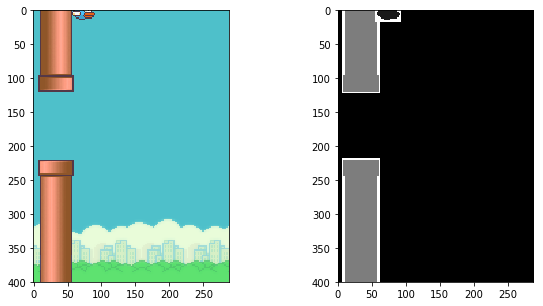

In [409]:
class TubePosition:
    def __init__(self, position, middle):
        self.top_coords = middle-370, position
        self.bottom_coords = middle + 50, position
        
        self.top_mask_coords = self.top_coords[0] - 2, self.top_coords[1] - 2
        self.bottom_mask_coords = self.bottom_coords[0] - 2, self.bottom_coords[1] - 2

def get_tube_positions(shift, N):
    all_tubes = [400 + 152 * n for n in range(N+1)]
    tubes_in_frame = filter(lambda x: shift <= x <= shift + 288 or shift <= x+52 <= shift + 288, all_tubes)
    
    return [pos - shift for pos in tubes_in_frame]

def calculate_tube_placement(position):
    middle = np.random.randint(90, 310)
    
    return TubePosition(position, middle)

def place_tubes():
    N = 20

    length = 400 + 152 * N
    shift = np.random.randint(length)
    tubes_in_frame = get_tube_positions(shift, N)
    
    return map(calculate_tube_placement, tubes_in_frame)

def place_tubes_on_image(image, mask, images):
    positions = place_tubes()
    
    for position in positions:
        place_image(image, images["inv_pipe"], position.top_coords)
        place_image(image, images["pipe"], position.bottom_coords) 
        
        place_mask(mask, images["inv_pipe_mask"], position.top_mask_coords)
        place_mask(mask, images["pipe_mask"], position.bottom_mask_coords)

def place_birb_on_image(image, mask, images):
    x = 57
    y = np.random.randint(-20, 396)
    
    place_image(image, images["birb"], (y, x))
    place_mask(mask, images["birb_mask"], (y-2, x-2))
    
    return image

def generate_frame(images):
    bg_copy = images["bg"].copy()
    mask = images["bg_mask"].copy()
    
    place_tubes_on_image(bg_copy, mask, images)
    place_birb_on_image(bg_copy, mask, images)
    
    return bg_copy, mask.astype(int)
    
def draw_images(image1, image2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))    
    ax1.imshow(image1)
    ax2.imshow(image2)
    
def color_mask(frame, mask):
    dictt = {0:0, 1:125, 2:25, 255:255}
    
    colored_mask = np.zeros(frame.shape[:2] + (3,), dtype=np.int32)
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            val = dictt[mask[x, y]]
            colored_mask[x, y, :] = (val, val, val)
    return colored_mask
    
frame, mask = generate_frame(all_sets[10])
color_mask = color_mask(frame, mask)
draw_images(frame, color_mask)

In [370]:
def adjust_image_position(image, small_image, position):
    x, y = position
    
    crop_x = 0, small_image.shape[0]
    crop_y = 0, small_image.shape[1]
    
    if x < 0:
        crop_x = -x, small_image.shape[0]
        x = 0
    elif x + small_image.shape[0] > image.shape[0]:
        crop_x = 0, image.shape[0] - x
        
    if y < 0:
        crop_y = -y, small_image.shape[1]
        y = 0
    elif y + small_image.shape[1] > image.shape[1]:
        crop_y = 0, image.shape[1] - y
        
    return small_image[crop_x[0]:crop_x[1], crop_y[0]:crop_y[1]], (x, y)

def place_image(image, small_image, position):
    small_image, position = adjust_image_position(image, small_image, position)
    x, y = position
    h, w = small_image.shape[:2]
    alpha = small_image[:, :, 3] / 255.0
    
    for c in range(3):
        image[x:x+h, y:y+w, c] = alpha * small_image[:, :, c] + (1-alpha) * image[x:x+h, y:y+w, c]
        
def place_mask(mask, object_mask, position):
    object_mask, position = adjust_image_position(mask, object_mask, position)
    x, y = position
    h, w = object_mask.shape[:2]
    
    mask[x:x+h, y:y+w] = object_mask

In [415]:
import warnings
warnings.filterwarnings('ignore')

images_folder = "data/images"
labels_folder = "data/labels"

images_per_set = 2000

def check_or_create(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
        
check_or_create(images_folder)
check_or_create(labels_folder)

num = 0

for set in tqdm_notebook(all_sets):
    for _ in tqdm_notebook(range(images_per_set), leave=False):
        frame, mask = generate_frame(set)
        fname = "{0}.png".format(str(num).zfill(6))
        
        imsave(os.path.join(images_folder, fname), frame)
        imsave(os.path.join(labels_folder, fname), mask)
        
        num += 1